In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import pandas as pd


import librosa #as _librosa
#from presets import Preset
# librosa = Preset(_librosa)
# librosa['sr'] = 44100
# librosa['n_fft'] = 4096
# librosa['hop_length'] = 1024

import librosa.display
import IPython.display as ipd
import os

%matplotlib notebook

# Function Definitions

In [2]:
def cutter(x, sr=None):
    '''
    cutter(x) takes wave amplitude array (x) and trims the edges, to avoid vocal onsets/stops at the beginning/end.  
    '''
    if sr == None:
        n1 = int(0.25*len(x))
        n2 = int(0.75*len(x))
    
        return x[n1:n2] 
    
    else:
        mid_idx = int(len(x)//2) # middle index
        hlf_wdw = int(0.5*(sr)/2.0) # half of 30 sec window in # of elements 
        return x[mid_idx-hlf_wdw:mid_idx+hlf_wdw] 

def formant_signal(x,order):
    '''
    formant_signal(x,order) takes wave amplitude array (x) and returns the LPC approximation 
    (s_formant) based on a linear autoregressive model to a given specified order (order).
    
    s_formant can be understood as the (sourceless) amplitude due to the vocal formants of the signal x.
    '''
    
    a = librosa.lpc(x, order) # (x,16)
    b = np.hstack([[0], -1 * a[1:]])
    s_formant = sp.signal.lfilter(b, [1], x)
    
    return s_formant

def residual(x,order,s=None):
    '''
    residual(x,order,s) subtracts the formants from the input signal x to yield the source wave (vocal cord buzz).
    '''
    if s is None: 
        s_formant = formant_signal(x,order)
        return (x-s_formant)
    else:
        return (x-s)

def audio_processor(x,sr=44100,order=16):
    '''
    Take input file and return ready for CNN 
    '''
    #x, sr = librosa.load(path_raw+file_test,sr=44100) #
    R_ = librosa.stft(residual(cutter(x,sr),order),n_fft=2048) # complex matrix 
    Rabs_ = np.abs(R_)
    RdB_ = librosa.amplitude_to_db(Rabs_, ref=np.max)
    RdB_expanded = np.expand_dims(RdB_, axis=2)
    RdB_ready = np.array( [RdB_expanded,] )
    #predict_2 = model.predict(   )
    
    return RdB_ready

In [3]:
 
# get images into array of shape (num_images, im_f, im_t)
def get_image_array(path_mat,im_f,im_t):
    
    filelist = [x for x in os.listdir(path_mat) if not x.startswith('.')]

    Rabs_array = np.zeros((len(filelist),im_f,im_t))

    for index,file in enumerate(filelist[:]):

        Rabs_array[index,:,:] = np.loadtxt(path_mat+'R'+str(index)+'.txt')

    print(Rabs_array.shape)
    
    return Rabs_array

# Reduce label array to 3 classes
def get_y3(y):
    
    y3 = np.copy(y)
    
    for index,elem in enumerate(y):
        
        if int(elem) == 2:
            
            y3[index] = 1
            
        if int(elem) == 3:
            
            y3[index] = 2
            
    return y3


In [4]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Path Management

In [3]:
# Specify Data Paths
path_raw =  os.path.abspath(os.pardir+"/Data/Data_Raw_Labeled/") + "/"
path_mat =  os.path.abspath(os.pardir+"/Data/Data_Mat/") + "/"
path_lab =  os.path.abspath(os.pardir+"/Data/Data_Lab/") + "/"
path_input =  os.path.abspath(os.pardir+"/Data/Data_Input/") + "/"

path_raw

'/Users/tamiro/Desktop/Insight/Code/SafeSing/SafeSing_Project/Data/Data_Raw_Labeled/'

In [6]:
# Specify the Order of the Formant Approximation
order = 16

# Process Audio to Images

In [48]:
# Process waves from Data_Raw_Labeled into abs(amplitude) images, dump into path_mat
# labels B: Breathy , N: Neutral, F: Flow, P: Pressed

save = True # set to True to save output

# counters
cb = 0 # count breathy
cn = 0 # count neutral
cf = 0 # count flow
cp = 0 # count pressed

# get all files in the path_raw folder
filelist = [x for x in os.listdir(path_raw) if not x.startswith('.')]

# initialize labels (y) array - one label for every input file.
y = np.zeros(len(filelist),dtype=int)

for index, file in enumerate(filelist[:]):
    
    print('index=',index)
    
    if 'breathy' in file:
        label = 0 
        cb += 1
    if 'neutral' in file:
        label = 1 
        cn += 1
    if 'flow' in file:
        label = 2 
        cf += 1
    if 'pressed' in file:
        label = 3 
        cp += 1
    try:
        x, sr = librosa.load(path_raw+file,sr=44100) #
        if len(x) < 22050: # if less than half a second
            print('WARNING, INPUT LESS THAN 30 SECS!')
        #print(x.shape)
    except:
        print(file+'has an issue')
    
    R = librosa.stft(residual(cutter(x,sr),order),n_fft=2048) # complex matrix 
    Rabs = np.abs(R) # square root of the spectrogram matrix
    #print(R.shape)
    
    y[index] = label
    
    if save==True:
        np.savetxt(path_mat+'R'+str(index)+'.txt',Rabs)

if save==True:
    np.savetxt(path_lab+'y'+'.txt',y)
    
print('counts:',cb,cn,cf,cp)
print('len_file_list:'+str(len(filelist))+' =? '+str(cb+cn+cf+cp))

index= 0
index= 1
index= 2
index= 3
index= 4
index= 5
index= 6
index= 7
index= 8
index= 9
index= 10
index= 11
index= 12
index= 13
index= 14
index= 15
index= 16
index= 17
index= 18
index= 19
index= 20
index= 21
index= 22
index= 23
index= 24
index= 25
index= 26
index= 27
index= 28
index= 29
index= 30
index= 31
index= 32
index= 33
index= 34
index= 35
index= 36
index= 37
index= 38
index= 39
index= 40
index= 41
index= 42
index= 43
index= 44
index= 45
index= 46
index= 47
index= 48
index= 49
index= 50
index= 51
index= 52
index= 53
index= 54
index= 55
index= 56
index= 57
index= 58
index= 59
index= 60
index= 61
index= 62
index= 63
index= 64
index= 65
index= 66
index= 67
index= 68
index= 69
index= 70
index= 71
index= 72
index= 73
index= 74
index= 75
index= 76
index= 77
index= 78
index= 79
index= 80
index= 81
index= 82
index= 83
index= 84
index= 85
index= 86
index= 87
index= 88
index= 89
index= 90
index= 91
index= 92
index= 93
index= 94
index= 95
index= 96
index= 97
index= 98
index= 99
index= 100

index= 755
index= 756
index= 757
index= 758
index= 759
index= 760
index= 761
index= 762
index= 763
index= 764
index= 765
index= 766
index= 767
index= 768
index= 769
index= 770
index= 771
index= 772
index= 773
index= 774
index= 775
index= 776
index= 777
index= 778
index= 779
index= 780
index= 781
index= 782
index= 783
index= 784
index= 785
index= 786
index= 787
index= 788
index= 789
index= 790
index= 791
index= 792
index= 793
index= 794
index= 795
index= 796
index= 797
index= 798
index= 799
index= 800
index= 801
index= 802
index= 803
index= 804
index= 805
index= 806
index= 807
index= 808
index= 809
index= 810
index= 811
index= 812
index= 813
index= 814
index= 815
index= 816
index= 817
index= 818
index= 819
index= 820
index= 821
index= 822
index= 823
index= 824
index= 825
index= 826
index= 827
index= 828
index= 829
index= 830
index= 831
index= 832
index= 833
index= 834
index= 835
index= 836
index= 837
index= 838
index= 839
index= 840
index= 841
index= 842
index= 843
index= 844
index= 845

# Model 1

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [8]:
# static parameters by design (for 0.5 sec recording, sr=44100, n_fft=2048)
im_f= 1025
im_t= 44

n_samples = 909

[[0.36108348 0.2931862  0.1931966  ... 0.11681895 0.03932764 0.0279549 ]
 [0.22300652 0.15983387 0.07983206 ... 0.06578445 0.06847872 0.0579765 ]
 [0.0908418  0.02897198 0.06268389 ... 0.00770415 0.02337417 0.07577303]
 ...
 [0.39476186 0.19781614 0.0012415  ... 0.00086136 0.02926729 0.06359355]
 [0.39346286 0.19611976 0.00100069 ... 0.00131003 0.02819169 0.06311223]
 [0.3930693  0.19692247 0.00050041 ... 0.00096408 0.02809815 0.06249082]]
(1025, 44)


<IPython.core.display.Javascript object>


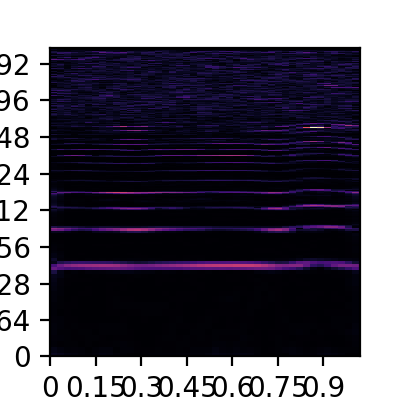

In [10]:
# Sample image
Rabs = np.loadtxt(path_mat+'R'+str(0)+'.txt')
print(Rabs)
print(Rabs.shape)
plt.figure(figsize=(2,2))
librosa.display.specshow(Rabs, x_axis='time', y_axis='log')

## Model Input Prep

In [63]:
# Pre-process data for CNN

# Rabs_array = get_image_array(path_mat,im_f,im_t)

# y = np.loadtxt(path_lab+'y'+'.txt')
# y3 = get_y3(y)

# np.savetxt(path_input+'R_array'+'.txt',Rabs_array.flatten())
# np.savetxt(path_input+'Y3'+'.txt',y3)

(909, 1025, 44)


In [66]:
# Load Data for CNN
Rabs_array = np.loadtxt(path_input+'R_array'+'.txt').reshape((n_samples,im_f,im_t))
y3 = np.loadtxt(path_input+'Y3'+'.txt')

print(Rabs_array.shape)
print(y3.shape)

In [68]:
# Log the abs(amplitude) to dBs.
RdB = librosa.amplitude_to_db(Rabs_array, ref=np.max)
RdB.shape

(909, 1025, 44)

# Train the Model

In [75]:
# Train_Test_Split
train_images, test_images, train_labels, test_labels = train_test_split(RdB, y3, test_size=0.3, random_state=40)

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(im_f, im_t, 1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(3, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [76]:
# Train the model.
model.fit(
  train_images,
  to_categorical(train_labels),
  epochs=30,
  validation_data=(test_images, to_categorical(test_labels)),
)

Epoch 1/30
20/20 [==============================] - 4s 205ms/step - loss: 523.1538 - accuracy: 0.3915 - val_loss: 243.2670 - val_accuracy: 0.3626
Epoch 2/30
20/20 [==============================] - 4s 198ms/step - loss: 78.6538 - accuracy: 0.5252 - val_loss: 17.1902 - val_accuracy: 0.6484
Epoch 3/30
20/20 [==============================] - 4s 200ms/step - loss: 22.4521 - accuracy: 0.6069 - val_loss: 18.5669 - val_accuracy: 0.6300
Epoch 4/30
20/20 [==============================] - 4s 205ms/step - loss: 12.9790 - accuracy: 0.6903 - val_loss: 16.1667 - val_accuracy: 0.6813
Epoch 5/30
20/20 [==============================] - 4s 213ms/step - loss: 6.1976 - accuracy: 0.8066 - val_loss: 5.0334 - val_accuracy: 0.7473
Epoch 6/30
20/20 [==============================] - 4s 219ms/step - loss: 1.7541 - accuracy: 0.9072 - val_loss: 3.8066 - val_accuracy: 0.7802
Epoch 7/30
20/20 [==============================] - 4s 216ms/step - loss: 0.6643 - accuracy: 0.9465 - val_loss: 3.5801 - val_accuracy: 0.7

In [77]:
#model.save_weights('ssing_cnn_v1.h5')

# Predictions & Confusion Matrices

In [79]:
predictions = model.predict(test_images[:])
cm =confusion_matrix(test_labels, np.argmax(predictions, axis=1))

<IPython.core.display.Javascript object>


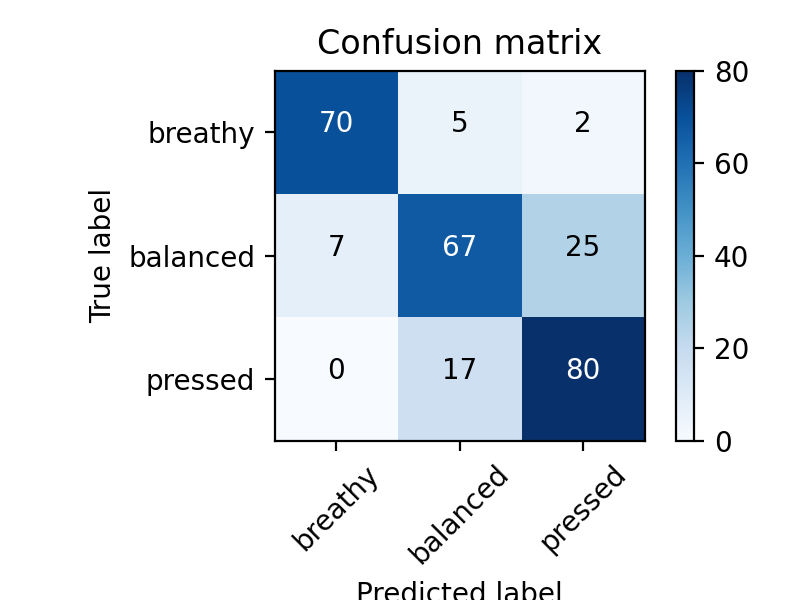

In [80]:
plot_confusion_matrix(cm,['breathy','balanced','pressed'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [16]:
# Testing particular wave files
filelist = [x for x in os.listdir(path_raw) if not x.startswith('.')]
err_indices = []
for index in range(0,2):#n_samples
    file_test = filelist[index]
    
    #RdB_1 = np.expand_dims(RdB[index], axis=2)
    #predict_1 = model.predict( np.array( [RdB_1,] )  )
    
    x, sr = librosa.load(path_raw+file_test,sr=44100) #
    print(cutter(x,sr).dtype)
    
    R = librosa.stft(residual(cutter(x,sr),order),n_fft=2048) # complex matrix 
    Rabs = np.abs(R)
    RdB_2 = np.expand_dims(librosa.amplitude_to_db(Rabs, ref=np.max), axis=2)
#    predict_2 = model.predict( np.array( [RdB_2,] )  )
    
#     if not (np.argmax(predict_1, axis=1)[0]==np.argmax(predict_2, axis=1)[0]):
#         add_str = ', Error at index =' +str(index)
#         err_indices.append(index)
#     else:
#         add_str = ''
        
    #print(str(np.argmax(predict_1, axis=1)[0])+' =? '+str(np.argmax(predict_2, axis=1)[0])+add_str)
    
print(err_indices)

float32
float32
[]


In [108]:
err_indices_1 = err_indices

In [112]:
err_indices_2 = err_indices

In [113]:
# 86 errors - 10% ! WHY?
print('num_errs_1=',len(err_indices_1))
print('num_errs_2=',len(err_indices_2))

num_errs_1= 86
num_errs_2= 86


In [114]:
err_indices_2==err_indices_1
# Errors are consistent.

True

In [4]:
x, sr = librosa.load("dona_straight_cut.wav",sr=44100)

In [5]:
import librosa.display
import IPython.display as ipd


In [6]:

ipd.Audio(x, rate=44100) #-/


In [8]:
#pitches, magnitudes = librosa.piptrack(y=x, sr=sr)
#pitches.shape

In [7]:
chunk_size = 22050
      
class_array = np.zeros(int(np.ceil(len(x)/chunk_size)))

sr=44100

In [87]:
chunk_lab = np.zeros(len(class_array))

for chunk in range(len(class_array)):
    # print(chunk)
    
    # within this bucket, compare the average pitch to the start and end pitches
    # if the stardard deviation is within a quarter tone of the mean, then good 
    
    wavelet = x[chunk*chunk_size:(chunk+1)*chunk_size]
    
    f0, voiced_flag, voiced_probs = librosa.pyin(y=wavelet,sr=44100, fmin=librosa.note_to_hz('C3'), fmax=librosa.note_to_hz('C5'))
    
    avg = np.nanmean(f0)
    std = np.nanstd(f0)
    #print(avg-std,avg+std)
    #print(avg*(1 - 35/36),avg*(1 + 35/36))
    if np.count_nonzero(voiced_flag == False) > 8:
        
        chunk_lab[chunk] = 0
    
    else:
        
        if (avg*(35/36) < avg - std) and (avg*(36/35) > avg + std): # within a semitone

            # classify this piece
            chunk_lab[chunk] = 2
            
        else:
            
            # don't classify
            
            chunk_lab[chunk] = 1
            

0
nan nan
nan nan
1


<ipython-input-87-89fe0346f01c>:14: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(f0)
/Users/tamiro/anaconda3/envs/safesing1/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


nan nan
nan nan
2
nan nan
nan nan
3
340.5823414467562 371.4225272008786
9.888956508994932 702.1159121386399
4
237.29930532030573 332.6560428189928
7.916046501934705 562.0393016373638
5
441.58905564647995 452.6596650271911
12.420121120467659 881.8285995532035
6
449.76931775219924 451.89162556779985
12.523068657222215 889.1378746627769
7
391.26351822025305 452.4644515037285
11.718444023944194 832.0095257000374
8
277.6590661784598 367.8962543229522
8.96604611807517 636.5892743833368
9
454.4698375015491 502.4418627694602
13.290440281541802 943.6212599894675
10
477.9209722695291 483.15914274838997
13.348334930804437 947.7317800871147
11
443.4363900224245 486.432232615326
12.914841981079874 916.9537806566707
12
444.8324951561191 449.9631685454127
12.427717551410169 882.3679461501217
13
391.98275036511995 431.43040722504463
11.436293855418958 811.9768637347456
14
357.03311482634984 402.61669515306204
10.550691805269615 749.0991181741423
15
356.9818518758863 362.0555775557154
9.986630964327805

In [88]:
f0, voiced_flag, voiced_probs = librosa.pyin(y=x,sr=44100, fmin=librosa.note_to_hz('C3'), fmax=librosa.note_to_hz('C5'))
times = librosa.times_like(f0,sr=44100)
#f0[np.isnan(f0)] = 0

In [79]:
chunk_lab
from numpy import nan

In [80]:
A4 = 440
C0 = A4*np.power(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    print(freq)
    if np.isnan(freq):
        return np.nan
    else:
        h = round(12*np.log2(freq/C0))
        print(h)
        octave = h // 12
        
        n = int(h % 12)
        print(octave, n)
        return name[n] + str(int(octave))

In [134]:
ref_values = 261.3 * (2.0 ** np.linspace(-2.0, 2.0, 2*24))
ref_ticks = librosa.hz_to_note(261.3 * (2.0 ** np.linspace(-2.0, 2.0, 2*24)))

In [155]:
ref_values[:]

array([  65.325     ,   69.29453623,   73.50528513,   77.97190423,
         82.70994172,   87.73589059,   93.06724607,   98.72256647,
        104.72153783,  111.08504244,  117.83523151,  124.99560228,
        132.59107984,  140.64810388,  149.19472071,  158.26068089,
        167.87754284,  178.07878262,  188.89991051,  200.37859461,
        212.55479195,  225.47088759,  239.17184216,  253.70534836,
        269.121997  ,  285.47545306,  302.82264256,  321.22395065,
        340.74343187,  361.44903306,  383.41282996,  406.71127802,
        431.42547861,  457.64146128,  485.45048327,  514.94934713,
        546.24073772,  579.43357965,  614.64341643,  651.99281268,
        691.6117808 ,  733.63823348,  778.21846383,  825.50765461,
        875.67041838,  928.88137057,  985.32573727, 1045.2       ])

In [89]:

y_values = 261.3 * (2.0 ** np.linspace(0.0, 1.0, 12))
y_ticks = librosa.hz_to_note(261.3 * (2.0 ** np.linspace(-0.0, 1.0, 12)))


In [136]:
import seaborn as sns
from matplotlib import rc,rcParams

<IPython.core.display.Javascript object>


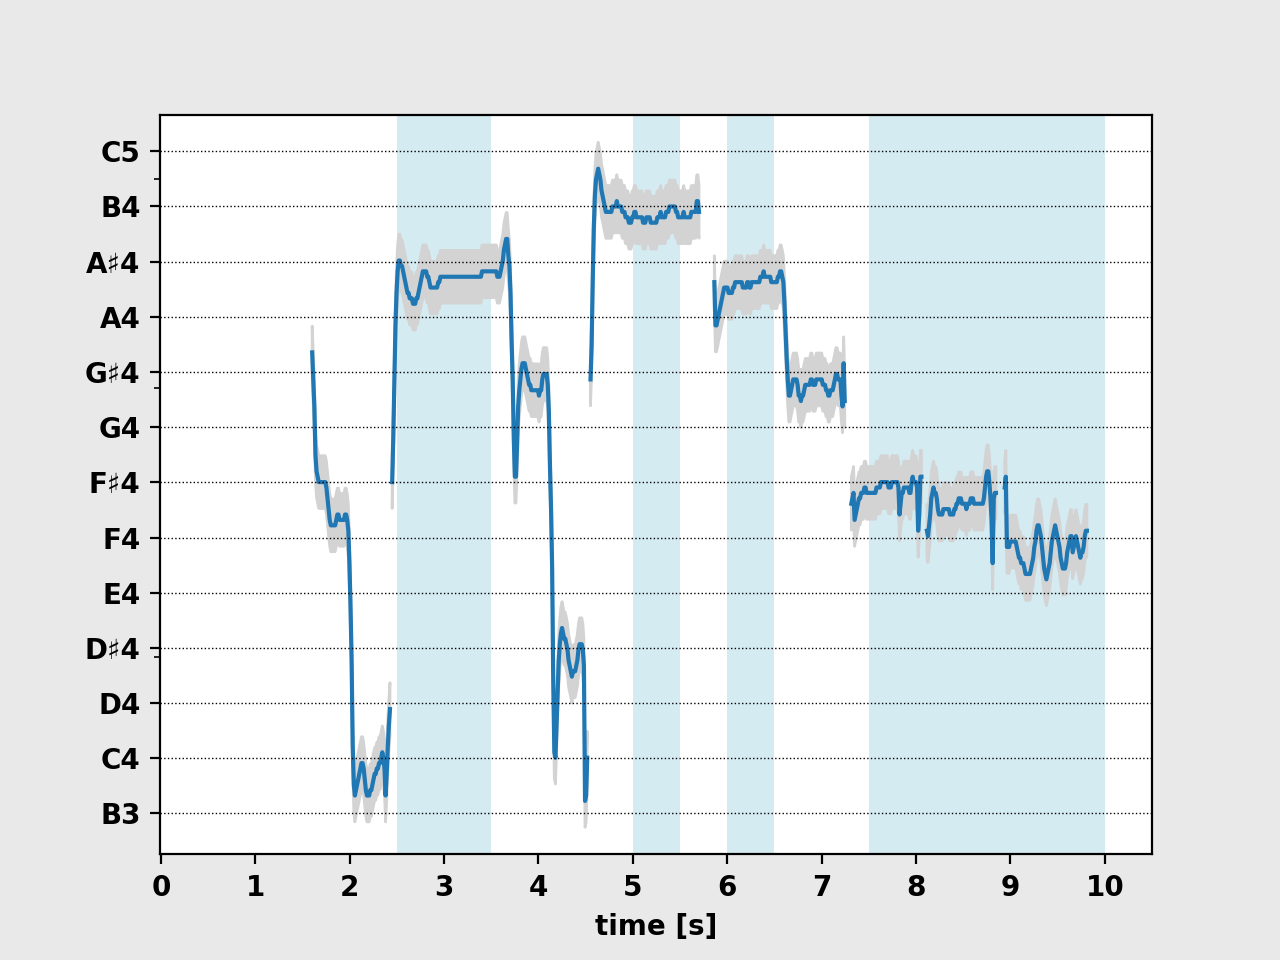

505.4272761986953
0.0
0.0
0.0
0.0
1.0
2.0
2.0
1.0
1.0
1.0
2.0
0.0
2.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0


In [162]:
%matplotlib notebook
rc('font', weight='bold')
rcParams['text.latex.preamble'] = r'\usepackage{sfmath} \boldmath'

fig=plt.figure(0)
#f0[np.isnan(f0)] = 0

max_f = np.nanmax(f0)
min_f = np.nanmin(f0)

print(max_f)

plt.plot(times,f0)
# plt.plot(times,36/35*f0,linestyle='--',color='red',linewidth=0.3)
# plt.plot(times,35/36*f0,linestyle='--',color='red',linewidth=0.3) #17/18
#plt.plot(times,100*voiced_flag)

plt.fill_between(times, 35/36*f0,36/35*f0,color='lightgrey')
#sns.lineplot(times,f0)



for chunk in range(len(class_array)):
    #print(chunk)
    print(chunk_lab[chunk])
    if chunk_lab[chunk] == 0:
        col = 'w'
    if chunk_lab[chunk] == 1:
        col = 'w'#'r'
    if chunk_lab[chunk] == 2:
        col = 'lightblue'
    
    #plt.axvline((chunk+1)*chunk_size/sr,color=col,linestyle='--',linewidth=0.7)
    
    plt.axvspan((chunk)*chunk_size/sr, (chunk+1)*chunk_size/sr, facecolor=col, alpha=0.5, zorder=-1)
    #plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)
    
#for value in y_values:
for value in ref_values[np.logical_and((ref_values<(18/17)*max_f),(ref_values > min_f*(17/18) ))]:
    
    plt.axhline(value,color='k',linestyle=':',linewidth=0.5)
    
plt.semilogy()
ax = plt.gca()
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
#plt.yticks(y_values, y_ticks)
plt.yticks(ref_values, ref_ticks)


ax.set_xlim(left=-0.01)
ax.set_ylim(top=(18/17)*max_f,bottom=min_f*(17/18))
ax.set_xlabel('time [s]',weight = 'bold')
ax.set_xticks(range(0,int(np.ceil(times[-1])+1)))

fig.patch.set_facecolor('gainsboro')
fig.patch.set_alpha(0.59)

In [46]:
# sr=44100
# x, sr = librosa.load("f3_dona_straight.wav",sr=44100)
# y= x[int(2*sr):8*len(x)//15] #-/
# #from librosa import output
# import soundfile as sf
# sf.write('dona_straight_cut.wav', y, 44100)
# #librosa.output.write_wav(, y, sr=44100)